In [1]:
%load_ext autoreload
%autoreload 2

train_path = "../Datasets/Montgomery_Shenzen/Train"
test_path = "../Datasets/Montgomery_Shenzen/Test"
val_path = "../Datasets/Montgomery_Shenzen/Val" 

In [2]:
import sys 
sys.path.append('..')

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import time

/home/kit/anaconda3/envs/deformable_detr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from models.hybridDoubleSkip import Hybrid as DoubleSkip
from models.hybrid import Hybrid as Hybrid
from models.joint import Joint
from models.rasterize_finetune import Hybrid_Rasterize as Rasterize
from models.unet_joint import UNet_Joint
from models.unet import UNet
from models.hourglass import Hourglass
from models.hourglass_concat import Hourglass_Concat
from models.multi_task import Multi_Task

import os 
from torchvision import transforms
from utils.dataLoader_XR import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLungs
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'Landmarks')
sdf_path = os.path.join(test_path, 'SDF')
mask_path = os.path.join(test_path, 'Masks')
test_dataset = LandmarksDataset(img_path=img_path,
                                mask_path=mask_path,
                                sdf_path = sdf_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )

device = 'cuda:0'
#device = 'cpu'

In [6]:
A, AD, D, U, E, ED = genMatrixesLungs()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [94, 94, 94, 47, 47, 47]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 16
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5
config['n_classes'] = 2

In [7]:
UNet_1 = UNet(n_classes = 2, rtn_all=False).to(device)
UNet_1.load_state_dict(torch.load('../weights/Montgomery_Shenzen/UNet/1/bestDice.pt'))
UNet_1.eval()
print('Model loaded')

UNet_2 = UNet(n_classes = 2, rtn_all=False).to(device)
UNet_2.load_state_dict(torch.load('../weights/Montgomery_Shenzen/UNet/2/bestDice.pt'))
UNet_2.eval()
print('Model loaded')

UNet_3 = UNet(n_classes = 2, rtn_all=False).to(device)
UNet_3.load_state_dict(torch.load('../weights/Montgomery_Shenzen/UNet/3/bestDice.pt'))
UNet_3.eval()
print('Model loaded')

Model loaded
Model loaded
Model loaded


In [9]:
config['unet_weights'] = '../models/unet_weights/bestDice_Montgomery_Shenzen.pt'
config['n_classes'] = 2
config['rtn_all'] = False

UNet_Joint_1 = UNet_Joint(config).to(device)
UNet_Joint_1.load_state_dict(torch.load('../weights/Montgomery_Shenzen/UNet_Joint/1/bestDice.pt'))
UNet_Joint_1.eval()
print('Model loaded')

UNet_Joint_2 = UNet_Joint(config).to(device)
UNet_Joint_2.load_state_dict(torch.load('../weights/Montgomery_Shenzen/UNet_Joint/2/bestDice.pt'))
UNet_Joint_2.eval()
print('Model loaded')

UNet_Joint_3 = UNet_Joint(config).to(device)
UNet_Joint_3.load_state_dict(torch.load('../weights/Montgomery_Shenzen/UNet_Joint/3/bestDice.pt'))
UNet_Joint_3.eval()
print('Model loaded')

Model loaded
Model loaded
Model loaded


In [10]:
HybridGNet_1 = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HybridGNet/1/bestMSE.pt"))
HybridGNet_1.eval()
print('Model loaded')

HybridGNet_2 = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HybridGNet/2/bestMSE.pt"))
HybridGNet_2.eval()
print('Model loaded')

HybridGNet_3 = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HybridGNet/3/bestMSE.pt"))
HybridGNet_3.eval()
print('Model loaded')

Model loaded
Model loaded
Model loaded


In [11]:
config['l1'] = 6
config['l2'] = 5

HybridGNet_IGSC_1 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_IGSC_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HybridGNet_IGSC/1/bestMSE.pt"))
HybridGNet_IGSC_1.eval()
print('Model loaded')

HybridGNet_IGSC_2 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_IGSC_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HybridGNet_IGSC/2/bestMSE.pt"))
HybridGNet_IGSC_2.eval()
print('Model loaded')

HybridGNet_IGSC_3 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_IGSC_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HybridGNet_IGSC/3/bestMSE.pt"))
HybridGNet_IGSC_3.eval()
print('Model loaded')

6-5
Model loaded
6-5
Model loaded
6-5
Model loaded


In [12]:
config['unet_weights'] = '../models/unet_weights/bestDice_Montgomery_Shenzen.pt'
config['rtn_all'] = False

Hourglass_1 = Hourglass(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Hourglass/1/bestMSE.pt"))
Hourglass_1.eval()
print('Model loaded')

Hourglass_2 = Hourglass(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Hourglass/2/bestMSE.pt"))
Hourglass_2.eval()
print('Model loaded')

Hourglass_3 = Hourglass(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Hourglass/3/bestMSE.pt"))
Hourglass_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [13]:
config['unet_weights'] = '../models/unet_weights/bestDice_Montgomery_Shenzen.pt'
config['rtn_all'] = False

Hourglass_Concat_1 = Hourglass_Concat(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_Concat_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Hourglass_Concat/1/bestMSE.pt"))
Hourglass_Concat_1.eval()
print('Model loaded')

Hourglass_Concat_2 = Hourglass_Concat(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_Concat_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Hourglass_Concat/2/bestMSE.pt"))
Hourglass_Concat_2.eval()
print('Model loaded')

Hourglass_Concat_3 = Hourglass_Concat(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_Concat_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Hourglass_Concat/3/bestMSE.pt"))
Hourglass_Concat_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [14]:
config['l1'] = 6
config['l2'] = 5

HCD_1 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HCD_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HCD/1/bestMSE.pt"))
HCD_1.eval()
print('Model loaded')

HCD_2 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HCD_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HCD/2/bestMSE.pt"))
HCD_2.eval()
print('Model loaded')

HCD_3 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HCD_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/HCD/3/bestMSE.pt"))
HCD_3.eval()
print('Model loaded')

6-5
Model loaded
6-5
Model loaded
6-5
Model loaded


In [15]:
config['unet_weights'] = '../models/unet_weights/bestDice_Montgomery_Shenzen.pt'

Joint_1 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Joint/1/bestMSE.pt"))
Joint_1.eval()
print('Model loaded')

Joint_2 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Joint/2/bestMSE.pt"))
Joint_2.eval()
print('Model loaded')

Joint_3 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Joint/3/bestMSE.pt"))
Joint_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [16]:
config['unet_weights'] = '../models/unet_weights/bestDice_Montgomery_Shenzen.pt'
config['rtn_all'] = True

Joint_HCD_1 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_HCD_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Joint_HCD/1/bestMSE.pt"))
Joint_HCD_1.eval()
print('Model loaded')

Joint_HCD_2 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_HCD_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Joint_HCD/2/bestMSE.pt"))
Joint_HCD_2.eval()
print('Model loaded')

Joint_HCD_3 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_HCD_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Joint_HCD/3/bestMSE.pt"))
Joint_HCD_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [17]:
config['load'] = '../models/hybridgnet_weights/bestMSE_Montgomery_Shenzen.pt'

Rasterize_1 = Rasterize(config.copy(), D_t, U_t, A_t).to(device)
Rasterize_1.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Rasterize/1/bestMSE.pt"))
Rasterize_1.eval()
print('Model loaded')

Rasterize_2 = Rasterize(config.copy(), D_t, U_t, A_t).to(device)
Rasterize_2.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Rasterize/2/bestMSE.pt"))
Rasterize_2.eval()
print('Model loaded')

Rasterize_3 = Rasterize(config.copy(), D_t, U_t, A_t).to(device)
Rasterize_3.load_state_dict(torch.load("../weights/Montgomery_Shenzen/Rasterize/3/bestMSE.pt"))
Rasterize_3.eval()
print('Model loaded')

6-5
Model loaded
6-5
Model loaded
6-5
Model loaded


In [18]:
segModels = ['UNet_1', 'UNet_2', 'UNet_3', 
             'UNet_Joint_1', 'UNet_Joint_2', 'UNet_Joint_3', 
             'DiffRast_1', 'DiffRast_2', 'DiffRast_3']
regModels = ['HybridGNet_1', 'HybridGNet_2', 'HybridGNet_3',
             'HybridGNet_IGSC_1', 'HybridGNet_IGSC_2', 'HybridGNet_IGSC_3', 
             'Hourglass_1', 'Hourglass_2', 'Hourglass_3',
             'Hourglass_Concat_1', 'Hourglass_Concat_2', 'Hourglass_Concat_3',
             'Multi_Task_1', 'Multi_Task_2', 'Multi_Task_3',
             'Joint_HCD_1', 'Joint_HCD_2', 'Joint_HCD_3', 
             'Joint_1', 'Joint_2', 'Joint_3',  
             'HCD_1', 'HCD_2', 'HCD_3']

In [19]:
model_list = [Hourglass_Concat_1, Hourglass_Concat_2, Hourglass_Concat_3]
model_names = ['Hourglass_Concat_1', 'Hourglass_Concat_2', 'Hourglass_Concat_3']
save_output = True

## Calc Regression Metrics

In [20]:
results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):   
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            
            start = time.time()
            output = model_list[j](data)
            end = time.time()
            inference = end - start
            
            if model_names[j] in regModels:
                
                output_ = output[0]
                
                # calc mse
                output_ = output_.cpu().numpy().reshape(-1)
                error = mean_squared_error(target * 1024, output_ * 1024)
                aux = pd.DataFrame([[i, error, inference, model_names[j]]], columns=['i','MSE', 'Inference', 'Model'])
                results1 = pd.concat([results1,aux], ignore_index = True)
            
            elif model_names[j] in segModels:
                aux = pd.DataFrame([[i, np.nan, inference, model_names[j]]], columns=['i','MSE', 'Inference', 'Model'])
                results1 = pd.concat([results1,aux], ignore_index = True)
                
            else:
                print('\n', model_names[j], 'is not categorised in as a reg, seg or both model')

 79 of 79

In [21]:
print('------------ MSE ------------')
for j in range(0, len(model_list)):
    inference_speed = results1[results1['Model'] == model_names[j]]['Inference'].mean()
    mse_score = results1[results1['Model'] == model_names[j]]['MSE'].mean()
    print(model_names[j], ': %.3f MSE   %.5f Inference speed (s)' % (mse_score, inference_speed))

------------ MSE ------------
Hourglass_Concat_1 : 122.648 MSE   0.12139 Inference speed (s)
Hourglass_Concat_2 : 121.757 MSE   0.12107 Inference speed (s)
Hourglass_Concat_3 : 117.562 MSE   0.12098 Inference speed (s)


## Calc Segmentation Metrics

In [22]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.fun import reverseVector, drawBinary

In [23]:
def evalImageMetrics(blank, output, target):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)

    hdp = hd(ptest, target, voxelspacing = 0.35)
    dcp = dc(ptest, target)
    jcp = jc(ptest, target)
    
    return [dcp, hdp, jcp], ptest

def evalImageMetricsUNet(output, target_lungs):
    dcp = dc(output == 1, target_lungs)    
    hdp = hd(output == 1, target_lungs, voxelspacing = 0.35)
    jcp = jc(output == 1, target_lungs)
    
    return [dcp, hdp, jcp]

In [32]:
blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, mask = sample['image'], sample['mask'].numpy()
        
        data = torch.unsqueeze(data, 0).to(device)
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            
               
            if model_names[j] in segModels:
                if isinstance(output, tuple):
                    if len(output) == 2:
                        output = output[1] # if model is dual we choose the second output 
                    elif len(output) == 3:
                        output = output[0] # if DiffRast model
                        #output = F.interpolate(output.unsqueeze(0), (1024,1024))
                
                seg = torch.argmax(output[0,:,:,:], axis = 0).cpu().numpy()
                np.save('Montgomery_Shenzen/Predictions/'+model_names[j][:-2]+'/'+model_names[j][-1]+'/'+test_dataset.images[i].split('/')[-1].replace('.png', '.npy'), seg)
                
                metrics = evalImageMetricsUNet(seg, mask)
                aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice','HD','Jaccard'])
                results = pd.concat([results, aux], ignore_index = True)
                
            elif model_names[j] in regModels:
                output_ = output[0]
                output_ = output_.cpu().numpy().reshape(-1) 
                metrics, seg = evalImageMetrics(blank, output_ * 1024, mask)                
                np.save('Montgomery_Shenzen/Predictions/'+model_names[j][:-2]+'/'+model_names[j][-1]+'/'+test_dataset.images[i].split('/')[-1].replace('.png', '.npy'), seg)
                
                aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice','HD','Jaccard'])
                results = pd.concat([results, aux], ignore_index = True)
            
            else:
                print('\n', model_names[j], 'has no category..')

 79 of 79

In [33]:
results.to_pickle('Montgomery_Shenzen/Scores/' + model_names[0][:-2] + '_scores.pkl')
results

,i,Model,Dice,HD,Jaccard
0,0,Hourglass_Concat_1,0.966875,19.677970,0.935874
1,0,Hourglass_Concat_2,0.964459,19.631225,0.931358
2,0,Hourglass_Concat_3,0.967167,19.677970,0.936421
3,1,Hourglass_Concat_1,0.965000,24.241132,0.932368
4,1,Hourglass_Concat_2,0.964979,25.892904,0.932328
...,...,...,...,...,...
232,77,Hourglass_Concat_2,0.981308,12.149588,0.963302
233,77,Hourglass_Concat_3,0.981945,10.782045,0.964531
234,78,Hourglass_Concat_1,0.984132,7.078312,0.968759
235,78,Hourglass_Concat_2,0.983930,6.640783,0.968369


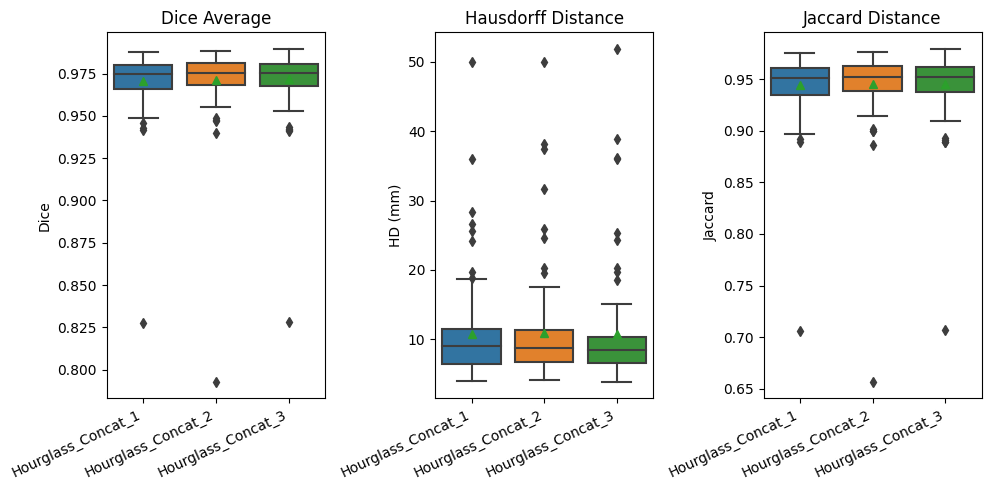

Dice
Hourglass_Concat_1 0.9708 +- 0.0192
Hourglass_Concat_2 0.9714 +- 0.0226
Hourglass_Concat_3 0.9715 +- 0.0194

Hausdorff
Hourglass_Concat_1 10.7667 +- 7.3483
Hourglass_Concat_2 10.9433 +- 7.8315
Hourglass_Concat_3 10.7480 +- 8.1937

Jaccard
Hourglass_Concat_1 0.9439 +- 0.0331
Hourglass_Concat_2 0.9452 +- 0.0378
Hourglass_Concat_3 0.9452 +- 0.0336



In [34]:
import matplotlib.ticker as mticker

results['Dice Average'] = results[['Dice', 'Dice']].mean(axis=1)
results['HD Average'] = results[['HD', 'HD']].mean(axis=1)
results['Jaccard Average'] = results[['Jaccard', 'Jaccard']].mean(axis=1)

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,3,1)
sns.boxplot(x = 'Model', y = 'Dice Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice Average')
plt.xlabel(None)

ax = plt.subplot(1,3,2)
sns.boxplot(x = 'Model', y = 'HD Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

ax = plt.subplot(1,3,3)
sns.boxplot(x = 'Model', y = 'Jaccard Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Jaccard')
plt.title('Jaccard Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num3.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.4f'%np.mean(results['Dice Average'][results['Model'] == model]), '+- %.4f' % np.std(results['Dice Average'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.4f'%np.mean(results['HD Average'][results['Model'] == model]), '+- %.4f' % np.std(results['HD Average'][results['Model'] == model]))

print('')

print('Jaccard')
for model in model_names:
    print(model, '%.4f'%np.mean(results['Jaccard Average'][results['Model'] == model]), '+- %.4f' % np.std(results['Jaccard Average'][results['Model'] == model]))

print('')